In [246]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('transactional-sample.csv')
plt.figure(figsize=(15,6))

############# DATA TRANSFORMATION ##############

df['transaction_date'] = pd.to_datetime(df['transaction_date'])

df['transaction_hour'] = df['transaction_date'].dt.hour
df['transaction_minute'] = df['transaction_date'].dt.minute
df['transaction_second'] = df['transaction_date'].dt.second

df['cbk_num'] = df['has_cbk'].case_when(
    caselist=[
        (df['has_cbk'] == True, 1),
        (df['has_cbk'] == False, 0)
    ]
)

hour_stats_transaction = df.groupby('transaction_hour').agg(
    transaction_count=('transaction_id', 'nunique'),
    transaction_hour_amount=('transaction_amount', 'sum')
).reset_index()

hour_stats_transaction['total_representative_transaction'] = (
    (hour_stats_transaction['transaction_count']/hour_stats_transaction['transaction_count'].sum())*100
)

hour_stats_transaction['total_representative_money_amount'] = (
    (hour_stats_transaction['transaction_hour_amount']/hour_stats_transaction['transaction_hour_amount'].sum())*100
)



hour_stats_cbk = df.groupby('transaction_hour').agg(
    cbk_count=('cbk_num', 'sum')
).reset_index()

hour_stats_cbk['total_representative_cbk'] = (
    (hour_stats_cbk['cbk_count']/hour_stats_cbk['cbk_count'].sum())*100
)

df_com_cbk = df[df['cbk_num'] == 1].copy()

cbk_amounts = df_com_cbk.groupby('transaction_hour').agg(
    cbk_hour_amount=('transaction_amount', 'sum')
)

hour_stats_cbk = pd.merge(hour_stats_cbk, cbk_amounts, on='transaction_hour', how='left')
hour_stats_cbk['cbk_hour_amount'] = hour_stats_cbk['cbk_hour_amount'].fillna(0)

<Figure size 1500x600 with 0 Axes>

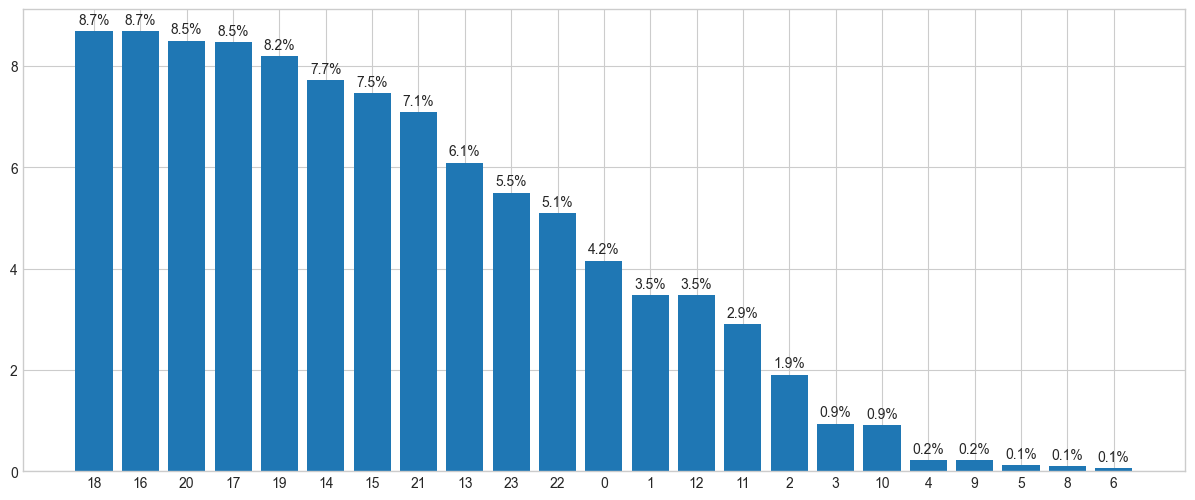

In [257]:
############## TRANSACTION DISTRIBUITION BY HOUR ##############

plt.figure(figsize=(15,6))

hour_stats_transaction_sorted = hour_stats_transaction.sort_values(
    by='transaction_count', ascending=False
)

hour_stats_transaction_sorted['cumsum_total_representative_transaction'] = hour_stats_transaction_sorted['total_representative_transaction'].cumsum()

hour_stats_transaction_bar = plt.bar(
    x=hour_stats_transaction_sorted['transaction_hour'].astype(str),
    height=hour_stats_transaction_sorted['total_representative_transaction'],
)

for bar in hour_stats_transaction_bar:
    height = bar.get_height()
    plt.annotate(f'{height:.1f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

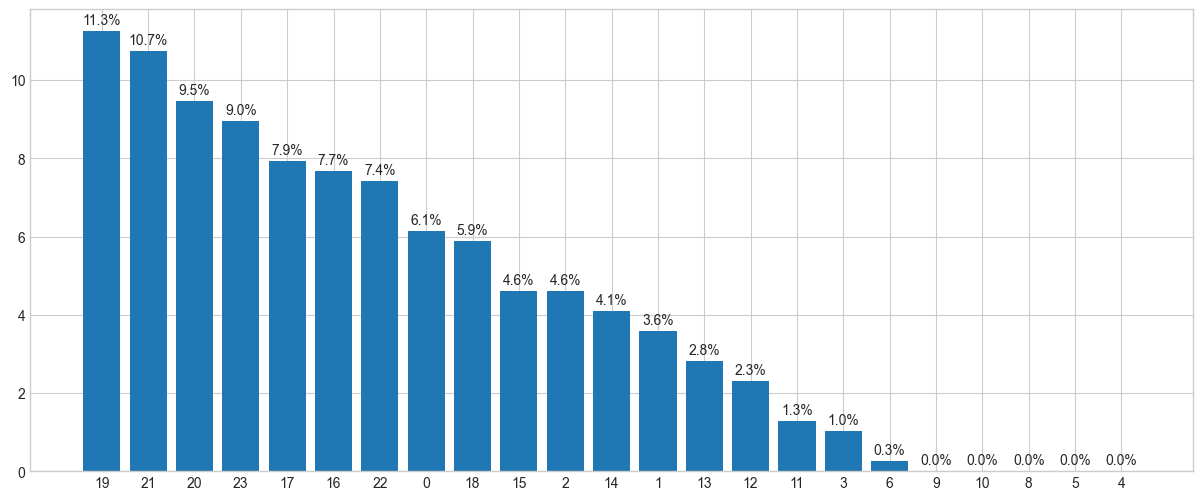

In [263]:
############## CHARGEBACK DISTRIBUTION BY HOUR ##############

hour_stats_cbk_sorted = hour_stats_cbk.sort_values(
    by='cbk_count', ascending=False
)

hour_stats_cbk_sorted['cumsum_total_representative_cbk'] = hour_stats_cbk_sorted['total_representative_cbk'].cumsum()

plt.figure(figsize=(15,6))
hour_stats_cbk_bar = plt.bar(
    x=hour_stats_cbk_sorted['transaction_hour'].astype(str),
    height=hour_stats_cbk_sorted['total_representative_cbk'],
)

for bar in hour_stats_cbk_bar:
    height = bar.get_height()
    plt.annotate(f'{height:.1f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')
    

C:\Users\guil_gomes\AppData\Local\Temp\ipykernel_27296\3225235756.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



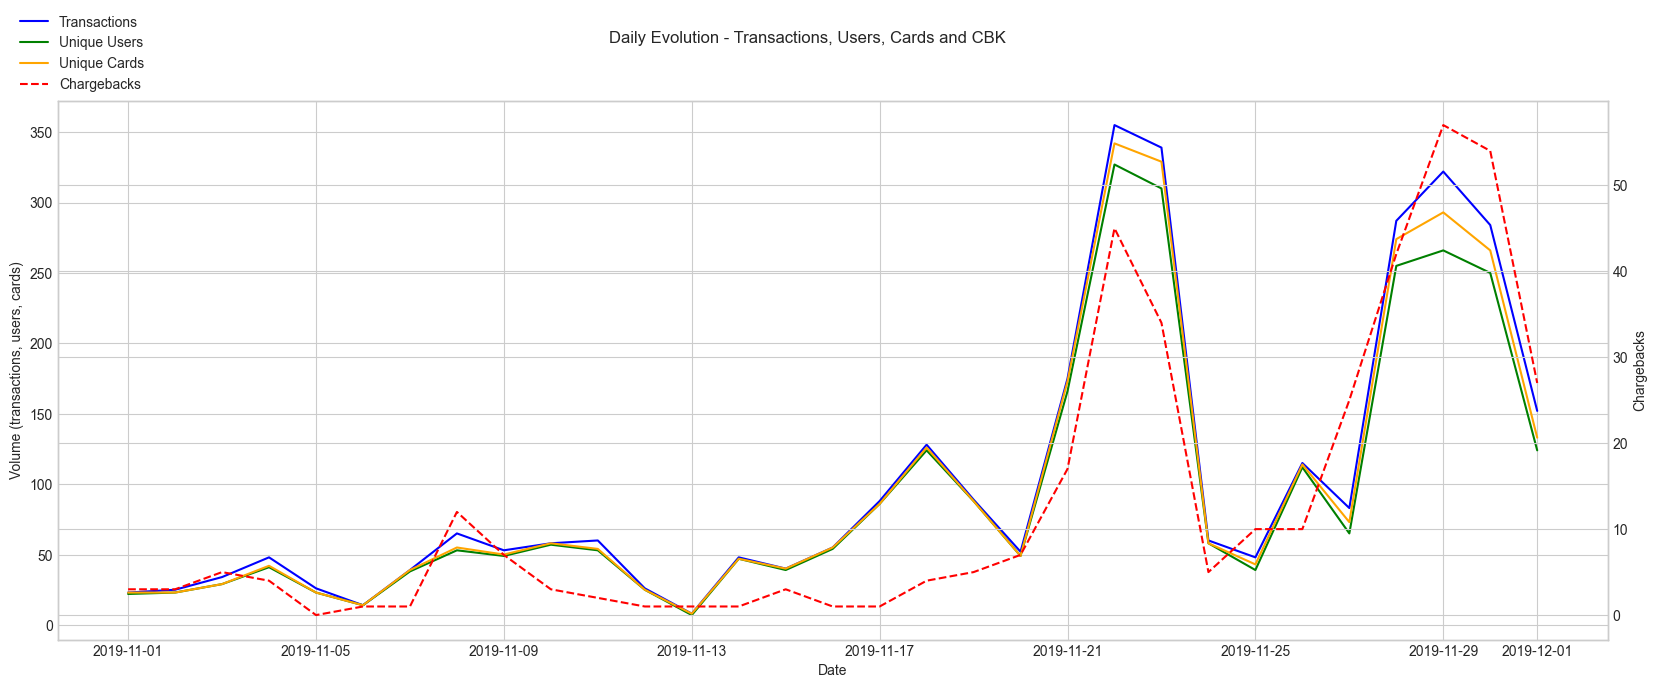

In [ ]:
############## EVOLUTION - TRANSACTIONS X USERS X CARDS X CHARGEBACKS ##############

timeseries_transaction_stats = df[['transaction_id', 'transaction_date', 'cbk_num', 'card_number', 'user_id', 'transaction_amount', 'device_id', 'merchant_id']]
timeseries_transaction_stats["transaction_date"] = pd.to_datetime(timeseries_transaction_stats["transaction_date"]).dt.date  # só data

agg_df = timeseries_transaction_stats.groupby("transaction_date").agg(
    transaction_count=("transaction_id", "count"),
    user_count=("user_id", "nunique"),
    card_count=("card_number", "nunique"),
    cbk_qtd=("cbk_num", "sum")
).reset_index()

fig, ax1 = plt.subplots(figsize=(20,7))

ax2 = ax1.twinx()

ax1.plot(agg_df["transaction_date"], agg_df["transaction_count"], label="Transactions", color="blue")
ax1.plot(agg_df["transaction_date"], agg_df["user_count"], label="Unique Users", color="green")
ax1.plot(agg_df["transaction_date"], agg_df["card_count"], label="Unique Cards", color="orange")

ax2.plot(agg_df["transaction_date"], agg_df["cbk_qtd"], label="Chargebacks", color="red", linestyle="--")

ax1.set_xlabel("Date")
ax1.set_ylabel("Volume (transactions, users, cards)")
ax2.set_ylabel("Chargebacks")

fig.suptitle("Daily Evolution - Transactions, Users, Cards and CBK")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 1.02))
plt.show()


In [ ]:
############## MERCHANT ANALYSIS: MERCHANT CHARGEBACKS PEAK ##############

date_window_ini_1 = '2019-11-21'
date_window_final_1 = '2019-11-23'

date_window_ini_2 = '2019-11-27'
date_window_final_2 = '2019-12-01'

window_peak_1 = timeseries_transaction_stats[(timeseries_transaction_stats['transaction_date']>=pd.to_datetime(date_window_ini_1).date()) &
                  (timeseries_transaction_stats['transaction_date']<=pd.to_datetime(date_window_final_1).date())]

window_peak_2 = timeseries_transaction_stats[(timeseries_transaction_stats['transaction_date']>=pd.to_datetime(date_window_ini_2).date()) &
                  (timeseries_transaction_stats['transaction_date']<=pd.to_datetime(date_window_final_2).date())]

top_peak_1 = window_peak_1.groupby('merchant_id').agg(cbk_sum=('cbk_num','sum'),
                                                  trans_sum=('transaction_id','nunique')).reset_index().sort_values('cbk_sum', ascending=False).head(10)

top_peak_2 = window_peak_2.groupby('merchant_id').agg(cbk_sum=('cbk_num','sum'),
                                                  trans_sum=('transaction_id','nunique')).reset_index().sort_values('cbk_sum', ascending=False).head(10)

total_cbk_per_merchant = df.groupby('merchant_id').agg(
    cbk=('cbk_num', 'sum')
).reset_index().sort_values(by='cbk', ascending=False)

top_peak_1 = top_peak_1.merge(
    total_cbk_per_merchant,
    'inner',
    on='merchant_id'
)

top_peak_2 = top_peak_2.merge(
    total_cbk_per_merchant,
    'inner',
    on='merchant_id'
)

top_peak_1['rate_cbk'] = (top_peak_1['cbk_sum']/top_peak_1['cbk'])*100
top_peak_2['rate_cbk'] = (top_peak_2['cbk_sum']/top_peak_2['cbk'])*100

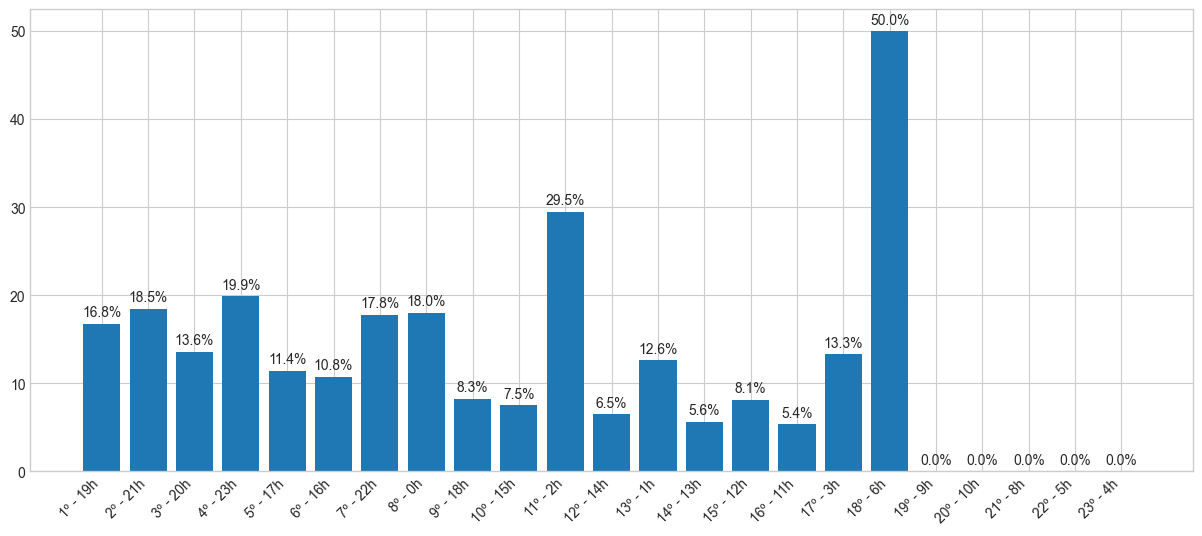

In [ ]:
############## TIME ANALYSIS: CHARGEBACK RATE PER HOUR ##############

transaction_cbk_stats = hour_stats_transaction.merge(
    hour_stats_cbk,
    'left',
    on='transaction_hour'
)

transaction_cbk_stats['percent_cbk'] = (transaction_cbk_stats['cbk_count']/transaction_cbk_stats['transaction_count'])*100
total_transacao = transaction_cbk_stats['transaction_count'].sum()

transaction_cbk_stats = transaction_cbk_stats.sort_values(by='cbk_count', ascending=False)
positions = range(len(transaction_cbk_stats)) 
labels = [f"{i+1}º - {hora}h" for i, hora in enumerate(transaction_cbk_stats['transaction_hour'])]



plt.figure(figsize=(15,6))

transaction_cbk_stats_bar = plt.bar(
    x=positions,
    height=transaction_cbk_stats['percent_cbk'],
)

for bar in transaction_cbk_stats_bar:
    height = bar.get_height()
    plt.annotate(f'{height:.1f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')
    
plt.xticks(ticks=positions, labels=labels, rotation=45, ha='right');

In [285]:
transaction_cbk_stats = transaction_cbk_stats.sort_values(by='cbk_hour_amount', ascending=False)
transaction_cbk_stats['monetary_cbk_freq'] = (transaction_cbk_stats['cbk_hour_amount']/transaction_cbk_stats['cbk_hour_amount'].sum())*100
transaction_cbk_stats['cumsum_total_representative_cbk'] = transaction_cbk_stats['monetary_cbk_freq'].cumsum()


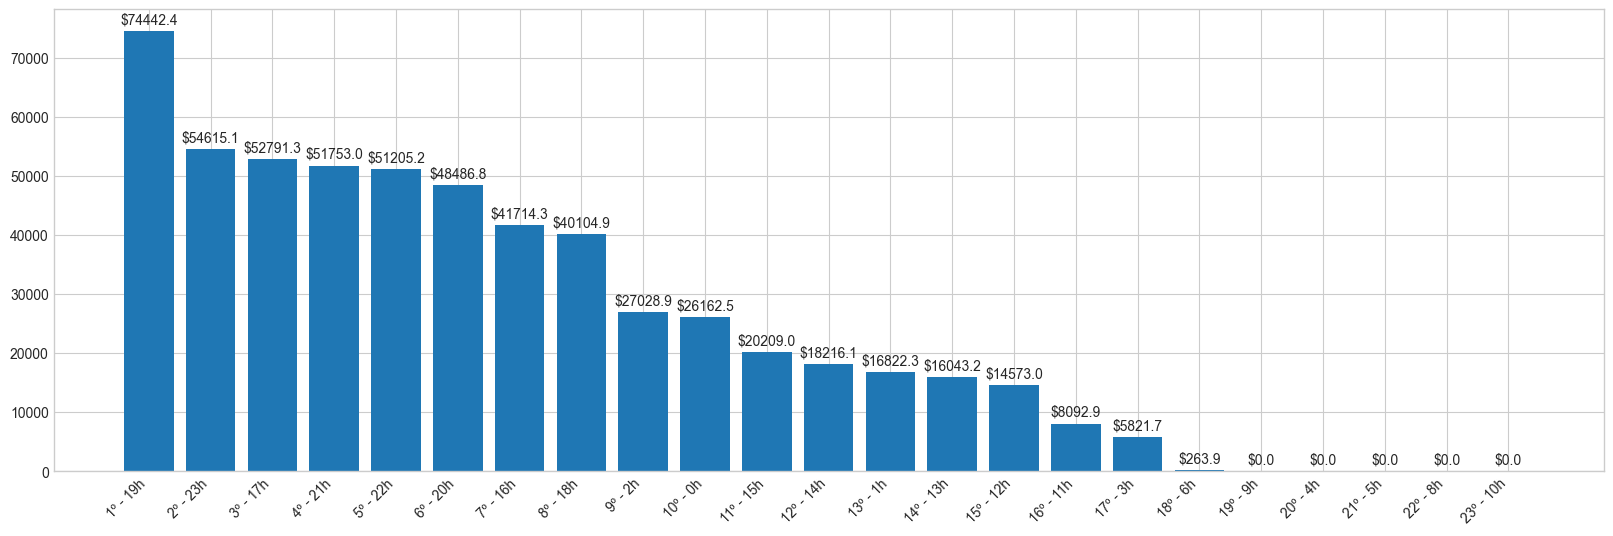

In [ ]:
############## TIME ANALYSIS: CHARGEBACK AMOUNT VALUES PER HOUR  ##############

transaction_cbk_stats = transaction_cbk_stats.sort_values(by='cbk_hour_amount', ascending=False)
positions = range(len(transaction_cbk_stats)) 
labels = [f"{i+1}º - {hora}h" for i, hora in enumerate(transaction_cbk_stats['transaction_hour'])]



plt.figure(figsize=(20,6))

monetary_percent_bar = plt.bar(
    x=positions,
    height=transaction_cbk_stats['cbk_hour_amount'],
)

for bar in monetary_percent_bar:
    height = bar.get_height()
    plt.annotate(f'${height:.1f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')
    
plt.xticks(ticks=positions, labels=labels, rotation=45, ha='right');

In [203]:
user_card_stats = df.groupby('user_id').agg(
    card_quantity=('card_number', 'nunique')
).reset_index()

user_device_stats = df.groupby('user_id').agg(
    device_quantity=('device_id', 'nunique')
).reset_index()

user_cbk_stats = df.groupby('user_id').agg(
    cbk_quantity=('cbk_num', 'sum')
).reset_index()

user_transaction_stats = df.groupby('user_id').agg(
    transaction_quantity=('transaction_id', 'nunique')
).reset_index()

user_amount_transaction_stats = df.groupby('user_id').agg(
    amount_user =('transaction_amount', 'sum')
).reset_index()

user_stats_full = user_card_stats.merge(
    user_device_stats,
    'left',
    on='user_id'    
).merge(
    user_cbk_stats,
    'left',
    on='user_id'
).merge(
    user_transaction_stats,
    'left',
    on='user_id'
).merge(
    user_amount_transaction_stats,
    'left',
    on='user_id'
)

user_stats_full['avg_amount'] = (user_stats_full['amount_user']/user_stats_full['transaction_quantity'])

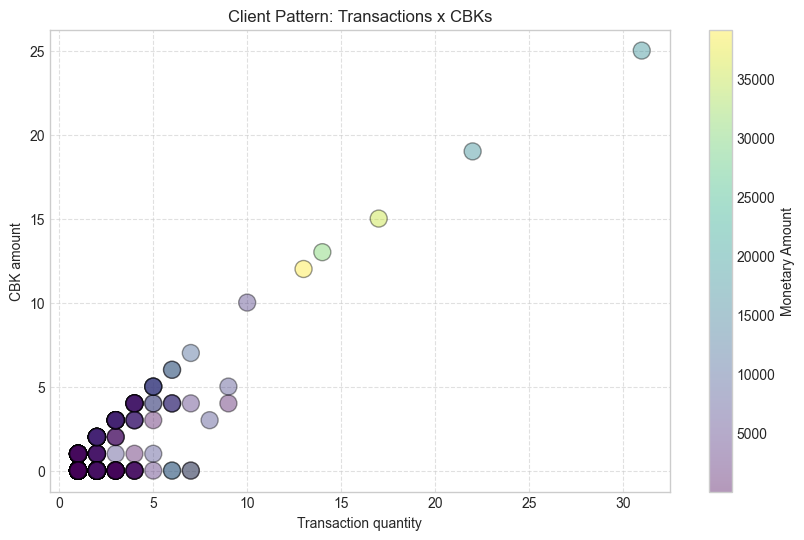

In [298]:
############## Client Pattern: Transactions x CBKs  ##############


fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(
    user_stats_full["transaction_quantity"], 
    user_stats_full["cbk_quantity"],  
    s=150,
    c=user_stats_full["amount_user"],           
    cmap="viridis", alpha=0.4, edgecolors="k"
)

plt.xlabel("Transaction quantity")
plt.ylabel("CBK amount")
plt.title("Client Pattern: Transactions x CBKs")

cbar = plt.colorbar(scatter)
cbar.set_label("Monetary Amount")

plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [214]:
merchant_card_stats = df.groupby('merchant_id').agg(
    card_quantity=('card_number', 'nunique')
).reset_index()

merchant_transaction_stats = df.groupby('merchant_id').agg(
    transaction_quantity=('transaction_id', 'nunique')
).reset_index()

merchant_device_stats = df.groupby('merchant_id').agg(
    device_quantity=('device_id', 'nunique')
).reset_index()

merchant_cbk_stats = df.groupby('merchant_id').agg(
    cbk_quantity=('cbk_num', 'sum')
).reset_index()

merchant_user_stats = df.groupby('merchant_id').agg(
    user_quantity=('user_id', 'nunique')
).reset_index()

merchant_stats_full = merchant_card_stats.merge(
    merchant_device_stats,
    'left',
    on='merchant_id'    
).merge(
    merchant_cbk_stats,
    'left',
    on='merchant_id'
).merge(
    merchant_user_stats,
    'left',
    on='merchant_id'
).merge(
    merchant_transaction_stats,
    'left',
    on='merchant_id'
)

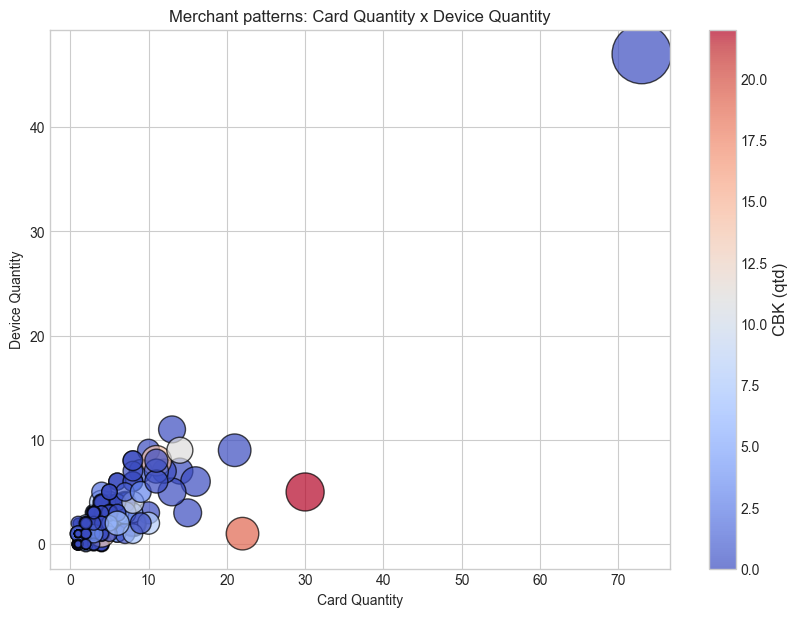

In [287]:
############## Merchant patterns: Card Quantity x Device Quantity  ##############

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 7))

scatter = ax.scatter(
    x=merchant_stats_full['card_quantity'],
    y=merchant_stats_full['device_quantity'],
    s=merchant_stats_full['transaction_quantity'] * 25,
    c=merchant_stats_full['cbk_quantity'],
    cmap='coolwarm',
    alpha=0.7,
    edgecolors='black',
    linewidth=1
)

plt.xlabel("Card Quantity")
plt.ylabel("Device Quantity")
plt.title("Merchant patterns: Card Quantity x Device Quantity")

cbar = fig.colorbar(scatter)
cbar.set_label('CBK (qtd)', fontsize=12)

plt.show()

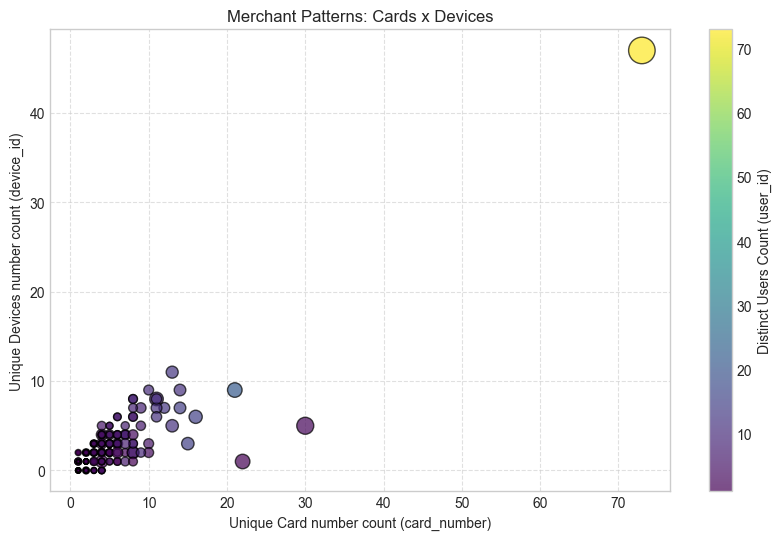

In [220]:
############## Merchant patterns: Card Quantity x Device Quantity  ##############

merchant_stats = df.groupby("merchant_id").agg(
    transaction_count=("transaction_amount", "count"),
    unique_users=("user_id", "nunique"),
    unique_cards=("card_number", "nunique"),
    unique_devices=("device_id", "nunique")
).reset_index()

plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    merchant_stats["unique_cards"], 
    merchant_stats["unique_devices"], 
    s=merchant_stats["transaction_count"] * 5,  
    c=merchant_stats["unique_users"],           
    cmap="viridis", alpha=0.7, edgecolors="k"
)

plt.xlabel("Unique Card number count (card_number)")
plt.ylabel("Unique Devices number count (device_id)")
plt.title("Merchant Patterns: Cards x Devices")

cbar = plt.colorbar(scatter)
cbar.set_label("Distinct Users Count (user_id)")

plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
